# Домашнее задание

В этом домашнем задании перед вами стоит задача научиться по фотографии лица человека предсказывать его пол, расу и возраст.

[Датасет](https://susanqq.github.io/UTKFace/), который мы будем использовать состоит из 20000 фотографий лиц людей в возрасте от 0 до 116 лет! В качестве разметки имеется пол (male/female), раса (white/black/asian/indian/other) и возраст. Классификация с сильной внутриклассовой изменьчивостью (от младенцев до пожилых людей). 
![alt text](https://susanqq.github.io/UTKFace/icon/samples.png)

Мы немного упростим себе задачу и воспользуемся версией датасета, где все картинки приведены к одному размеру и лица находятся в центре изображения.

Как решать такую задачу? Мы предлагаем вам воспользоваться **transfer learning и finetuning**. Т.е. взять за основу сеть, обученную на большом количестве данных для другой задачи и дообучить ее для нашей задачи.

## Задание 1

Датасетом, с которого чаще всего "переносят" знания, является известный нам ImageNet. Работая над классификатором кошек и собак на прошлом уроке мы воспользовались именно им. В этом задании мы возьмем за основу сеть, которая была обучена на датасете [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) для классификации лиц. Он содержит 3.3 миллиона изображений с 9000 разными персоналиями.

## Загрузка обученной модели

Сеть, которую мы будем дообучать мы возьмем из открытого источника: https://github.com/rcmalli/keras-vggface .

In [ ]:
# ! pip install git+https://github.com/rcmalli/keras-vggface.git

In [ ]:
# ! pip install gdown

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown
from pathlib import Path
from collections import Counter

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Т.к. мы решили воспользоваться чужой моделью, нам нужно сначала понять как с ней взаимодействовать. Для этого авторы часто прикладывают пример использования своих моделей. Его можно найти в README у автора репозитория.

In [2]:
# ! pip install keras_vggface

In [3]:
# ! pip install keras_applications --no-deps

In [4]:
# код из https://github.com/rcmalli/keras-vggface/blob/master/README.md
# при выполнении вызовет ошибку -- это нормально

from keras_vggface.vggface import VGGFace

vggface_model = VGGFace(model='resnet50') # or VGGFace() as default

In [5]:
# url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
# output = 'resnet50face.h5'
# gdown.download(url, output, quiet=False)

In [6]:
# from tensorflow.keras.models import load_model
# vggface_model = load_model("resnet50face.h5")

Модель загружена, а теперь посмотрим, что она из себя представляет. Это архитектура -- ResNet. На самом деле внутренности модели не очень важны для нас -- в дальнейшем мы заморозим бОльшую часть этой сети и будем рабоать только с последними слоями. Нам важно, что она обучена и мы имеем доступ к ее архитектуре и весам.

In [7]:
vggface_model.summary() # последний слой классифицирует на 8631 классов

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

Для проверки того, что помимо архитектуры мы правильно загрузили веса, проверим предсказания модели на следующем изображении: 

In [8]:
# ! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

После загрузки запустим полный пример из репозитория:

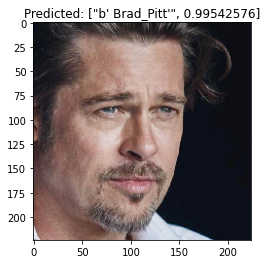

In [9]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img("brad_pitt.jpg", target_size=(224, 224)) # модель работает с картинками размера 224 на 224
x = image.img_to_array(img) # трансформируем изображение в массив
x = np.expand_dims(x, axis=0) # добавим новую ось к массиву
x = utils.preprocess_input(x, version=2) # мы используем resnet50 -- поэтому version2. Эта функция нам еще пригодится!

preds = vggface_model.predict(x) # модель -- известная нам keras model, вызываем predict
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}") # используем  decode_predictions из keras_vggface
plt.imshow(img)
plt.show()

## Загрузка данных
Мы убедились, что модель загружена правильно, узнали какой препроцессинг ей необходим (utils.preprocess_input(x, version=2)) и теперь можем перейти к загрузке наших данных.

In [10]:
# url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
# output = './UTKFace.tar.gz'
# gdown.download(url, output, quiet=False)
# ! tar -xzf /tmp/UTKFace.tar.gz -C ./
# url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
# output = 'train_val_split_utk.csv'
# gdown.download(url, output, quiet=False)

In [11]:
data_folder = Path("./UTKFace")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg']


In [12]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109150557335.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg


,img_name,age,race,gender
0,23_1_2_20170116172910708.jpg.chip.jpg,0.198276,2,1
1,28_0_1_20170113150719161.jpg.chip.jpg,0.241379,1,0
2,26_1_0_20170116234741431.jpg.chip.jpg,0.224138,0,1
3,37_0_3_20170119202516470.jpg.chip.jpg,0.318966,3,0
4,60_0_0_20170109013457906.jpg.chip.jpg,0.517241,0,0


In [13]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()

,is_train
img_name,
29_0_0_20170117180855986.jpg.chip.jpg,1
29_0_4_20170117202712541.jpg.chip.jpg,1
35_0_1_20170117104607288.jpg.chip.jpg,1
17_0_0_20170110231830374.jpg.chip.jpg,1
23_0_0_20170117194023317.jpg.chip.jpg,1


In [14]:
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [15]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

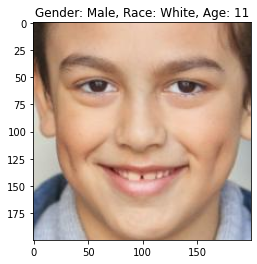

In [16]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Посмотрим на их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


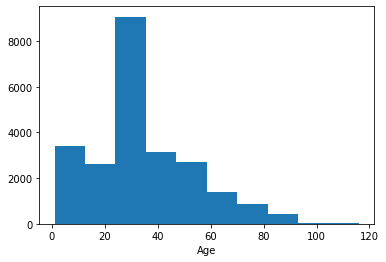

In [17]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]

print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

## Задание 2. Создание генератора данных для модели предсказания пола.
Предподготовка закончена. А теперь ваша очередь:) Мы начнем с создания модели предсказания пола. В этом задании вы должны реализовать генератор данных необходимый для последущего обучения модели. Мы предлагаем вам воспользоваться `tensorflow.keras.preprocessing.image.ImageDataGenerator`

a) Создайте генератор image_gen типа ImageDataGenerator с корректным препроцессингом, соответствующем keras_vggface.  
Аугментацию использовать не нужно. 

Какой препроцессинг корректный? Как мы знаем, перед применением обученных сетей нужно знать какой препроцессинг они проводят с данными. Т.к. эта модель не часть Keras, мы должны ответить на этот вопрос сами с помощью исходников автора этой сети. К счастью, он приводит пример использования на главной странице репозитория. Видно, что он использует функцию preprocess_input из utils. Значит ей мы и должны воспользоваться!

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface (см пример с Бредом Питом)
    """    
    
    preprocessed = utils.preprocess_input(image_, version=2)
    
    return preprocessed

# image_gen должен содержать ImageDataGenerator с правильной preprocessing_function
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

b)  Для генерации картинок раньше мы использовали `image_gen.flow_from_folder`. Но для этого данные должны быть расположены на диске с определенной структурой папок, что в данном случае не очень удобно. Поэтому вы должны воспользоваться более гибким `image_gen.flow_from_dataframe`, который позволяет генерировать данные с нужными классами используя датафрейм (мы его создали выше для вас).

**Ознакомьтесь с документацией по [ссылке](https://keras.io/preprocessing/image/) (раздел flow_from_dataframe) и создайте train_generator и val_generator для df_train и df_val соответственно.**
*  Генератор должен возвращать картинку и ее класс (male/female)
*  class_mode укажите "binary", directory=str(data_folder)
*  batch_size, image_size указаны ниже
*  train_generator должен перемешивать данные, а val_generator -- не должен
*  После выполнения клетки ниже вы должны увидеть текст: *Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.*




In [19]:
BATCH_SIZE = 128
IMAGE_SIZE = 224

train_generator_gender = image_gen.flow_from_dataframe(dataframe=df_train,
                                                x_col='img_name',
                                                y_col='gender',
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary',
                                                directory=str(data_folder),
                                                shuffle=True)

val_generator_gender = image_gen.flow_from_dataframe(dataframe=df_val,
                                              x_col='img_name',
                                              y_col='gender',
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              batch_size=BATCH_SIZE,
                                              class_mode='binary',
                                              directory=str(data_folder),
                                              shuffle=False)

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


In [20]:
sample_images, sample_labels = next(val_generator_gender)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE,), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1.], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Simple tests passed


Попробуем отобразить картинку и ее лейбл для проверки генерации:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Male


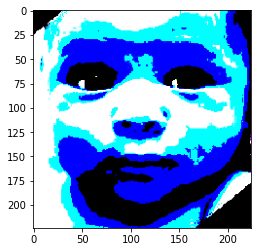

In [21]:
plt.imshow(sample_images[24])
print(gender_mapping[int(sample_labels[24])])
# мы получим очень странное изображение и это нормально. 
# matplotlib ожидает картинку с интесивностями от 0 до 1 если она типа float и от 0 до 255 если int.

In [22]:
print(sample_images[24].max(), sample_images[24].min()) # можно увидеть что значения яркостей типа float и в т.ч. отрицательные

144.5047 -131.0912


с) Реализуйте функцию `deprocess_image`, которая преобразует картинку исользуемую keras_vggface обратно к изображению, которое можно визуализировать с помощью `matplotlib`.
*  вам понадобится https://github.com/rcmalli/keras-vggface/blob/master/keras_vggface/utils.py
*  необходимо проделать операции preprocess_input в обратном порядке
*  наш случай: version=2, format="channels_last"

Male White


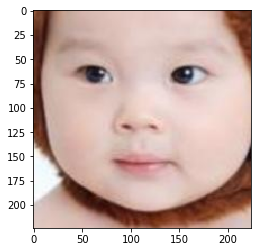

In [23]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib

    return: корректно отображаеая картинка типа np.uint8(!!). 

    ! работайте с копией картинки (image = np.copy(vggface_image)) !
    """
    
    image = np.copy(vggface_image)
    image[..., 0] += 91.4953
    image[..., 1] += 103.8827
    image[..., 2] += 131.0912
    image = image[..., ::-1]
    image = image.astype(np.uint8)

    return image

# теперь картинка должна отображаться корректно
plt.imshow(deprocess_image(sample_images[5]))
print(gender_mapping[int(sample_labels[5])], race_mapping[int(sample_labels[5])])

## Задание 3. Обучение модели предсказания пола

В этом задании вы должны обучить модель предсказания пола с точностью более 90% на валидационном сете. 

*   Возьмите за основу 'base_model' (определена ниже)
*   Вы должны сами решить сколько слоев замораживать и сколько полносвзяных слоев использовать. Рекомендуем начинать с модели с меньшим числом обучаемых параметров.
*   Используйте чекпоинты, чтобы не потерять веса лучшей модели. Они должны быть сохранены с именем "model_gender/checkpoint_best.h5"
*   Рекомендуется в model.fit(...) использовать steps_per_epoch=25, для того чтобы проверка на валидации происходила чаще и вы могли более точно отслеживать прогресс. Полная эпоха ~140 итераций.
*   За точность выше 94% -- дополнительные баллы.

In [36]:
# для начала "отрежем" от vggface_model последний слой классификатора 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.

base_model_gender = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten").output)
base_model_gender.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [37]:
base_model_gender.trainable = True
print("Количество слоев в базовой модели: ", len(base_model_gender.layers))

Количество слоев в базовой модели:  175


In [38]:
fine_tune_at = 153
for layer in base_model_gender.layers[:fine_tune_at]:
    layer.trainable = False
base_model_gender.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [39]:
# !pip install livelossplot

In [40]:
from livelossplot.tf_keras import PlotLossesCallback

In [43]:
# Обучение модели предсказания пола
model_gender = tf.keras.Sequential([base_model_gender, tf.keras.layers.Dense(1, activation='sigmoid')])
model_gender.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 2048)              23561152  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,563,201
Trainable params: 8,927,233
Non-trainable params: 14,635,968
_________________________________________________________________


In [44]:
model_gender.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00005),
                   loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
path = Path("model_gender")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.hdf5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', 
                                                verbose=1, save_best_only=True, mode='max')

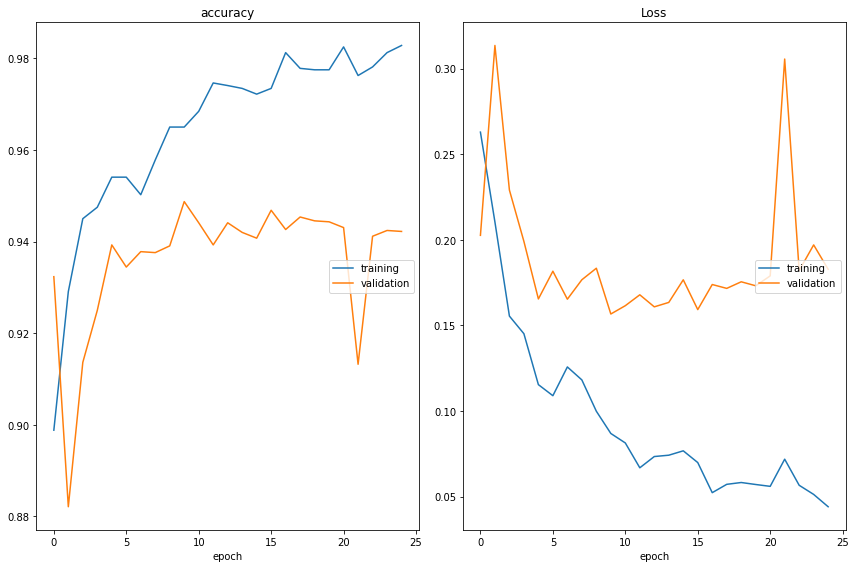

accuracy
	training         	 (min:    0.899, max:    0.983, cur:    0.983)
	validation       	 (min:    0.882, max:    0.949, cur:    0.942)
Loss
	training         	 (min:    0.044, max:    0.263, cur:    0.044)
	validation       	 (min:    0.157, max:    0.314, cur:    0.183)

Epoch 00025: val_accuracy did not improve from 0.94873


In [46]:
EPOCHS = 25
history = model_gender.fit(
    train_generator_gender,
    epochs=EPOCHS,
    validation_data=val_generator_gender,
    steps_per_epoch=25,
    callbacks=[PlotLossesCallback(), checkpoint])

In [48]:
model_gender = tf.keras.models.load_model("model_gender/checkpoint_best.hdf5")
loss, acc = model_gender.evaluate(val_generator_gender)
if acc < 0.9:
    print("Please, try harder!")
else:
    if acc >= 0.94:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 10s 243ms/step - loss: 0.1566 - accuracy: 0.9487
Well done!


In [49]:
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')

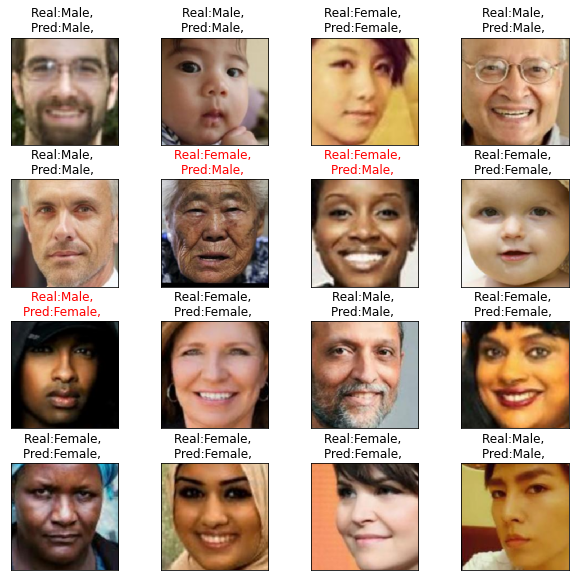

In [50]:
sample_validation_images, sample_validation_labels = next(val_generator_gender)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

## Задание 4. Обучение модели предсказания расы

В этом задании вы должны обучить модель предсказания расы с точностью более 80% на валидационном сете. 

*   Используя код аналогичный тому, что выше, реализуйте модель предсказания расы
*   Для начала определите генератор данных
    *  нужно указать class_mode="sparse" и изменить "y_col"
*   Используйте чекпоинты, чтобы не потерять веса лучшей модели. Они должны быть сохранены с именем "model_race/checkpoint_best.h5"
*   За точность выше 85% -- дополнительные баллы.



In [61]:
# vggface_model = tf.keras.models.load_model("resnet50face.h5")
base_model_race = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten").output)
base_model_race.trainable = True
base_model_race.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [62]:
print("Количество слоев в базовой модели: ", len(base_model_race.layers))

Количество слоев в базовой модели:  175


In [63]:
fine_tune_at = 169
for layer in base_model_race.layers[:fine_tune_at]:
    layer.trainable = False
base_model_race.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [64]:
BATCH_SIZE = 128
IMAGE_SIZE = 224

train_generator_race = image_gen.flow_from_dataframe(dataframe=df_train,
                                                x_col='img_name',
                                                y_col='race',
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size=BATCH_SIZE,
                                                class_mode='sparse',
                                                directory=str(data_folder),
                                                shuffle=True)

val_generator_race = image_gen.flow_from_dataframe(dataframe=df_val,
                                              x_col='img_name',
                                              y_col='race',
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              batch_size=BATCH_SIZE,
                                              class_mode='sparse',
                                              directory=str(data_folder),
                                              shuffle=False)

Found 18946 validated image filenames belonging to 5 classes.
Found 4759 validated image filenames belonging to 5 classes.


In [67]:
# Обучение модели предсказания расы
model_race = tf.keras.Sequential([base_model_race, tf.keras.layers.Dense(5, activation='softmax')])
model_race.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 2048)              23561152  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 10245     
Total params: 23,571,397
Trainable params: 1,062,917
Non-trainable params: 22,508,480
_________________________________________________________________


In [68]:
model_race.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00005),
                   loss='sparse_categorical_crossentropy',
                   metrics=['sparse_categorical_accuracy'])

In [69]:
path = Path("model_race")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.hdf5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_sparse_categorical_accuracy',
                                                verbose=1, save_best_only=True, mode='max')

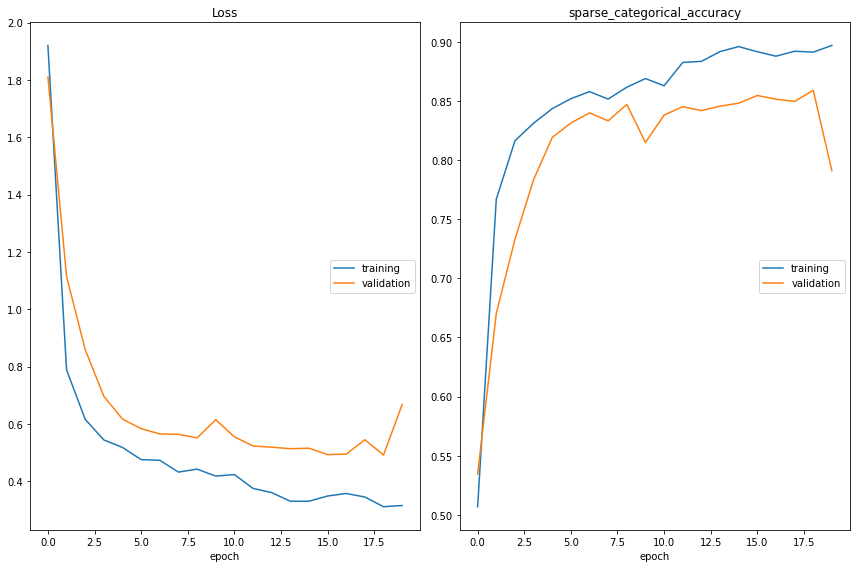

Loss
	training         	 (min:    0.311, max:    1.920, cur:    0.315)
	validation       	 (min:    0.491, max:    1.811, cur:    0.668)
sparse_categorical_accuracy
	training         	 (min:    0.507, max:    0.897, cur:    0.897)
	validation       	 (min:    0.534, max:    0.859, cur:    0.791)

Epoch 00020: val_sparse_categorical_accuracy did not improve from 0.85900


In [70]:
EPOCHS = 20
history = model_race.fit(
    train_generator_race,
    epochs=EPOCHS,
    validation_data=val_generator_race,
    steps_per_epoch=25,
    callbacks=[PlotLossesCallback(), checkpoint])

In [72]:
model_race = tf.keras.models.load_model("model_race/checkpoint_best.hdf5")
loss, acc = model_race.evaluate(val_generator_race)
if acc < 0.8:
    print("Please, try harder!")
else:
    if acc >= 0.85:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 10s 242ms/step - loss: 0.4915 - sparse_categorical_accuracy: 0.8590
Well done!


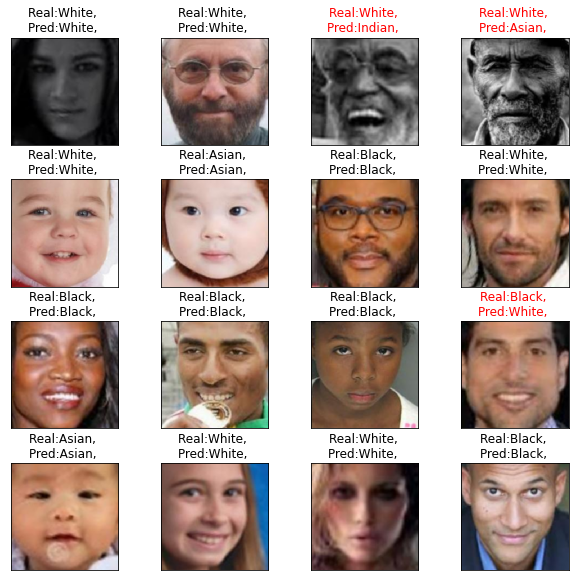

In [73]:
sample_validation_images, sample_validation_labels = next(val_generator_race)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

## Задание 5. Multitask learning

В этом задании мы могли бы обучить регрессор возраста по картинке, используя аналогичный уже написаному код. Но вы пойдем по другому пути. 

Если на каждый атрибут (возраст, раса, пол) создавать одну модель, то таких моделей получится 3. Очевидно, что для предсказания на новой картике необходимо будет произвести инференс трех сетей. Это может быть ресурсо-затратно и сложнее в поддержке. 

Какой же есть еще подход? Он называется Multitask learning. Его идея в том, чтобы обучать одну модель для решения сразу нескольких задач! Гибкость нейронных сетей позволяет это сделать достаточно логичными образом. Необходимо вместо одной "головы" для предсказания сделать несколько. Таким образом в нашей задаче одна будет отвечать за классификацию пола (1 выход, вероятность), вторая -- за классификацию расы (5 выходов, вероятности) и третья -- за предсказания возраста (1 выход, число).

### a) 
**Реализуйте модель сети с тремя "головами".**

*    Вам нужно вспомнить что такое Functional API для определения моделей, потому что необходимо определить архитектуру с тремя выходами. С помощью Sequential API этого сделать нельзя.
*    За основу возьмите base_model (определена ниже), добавьте к ее выходу 1-2 полносвязных слоя (количество нейронов определите сами)
*    К последнему слою добавьте три паралельных выхода: два с одним нейроном и один с пятью
*    При определении выходных слоев обязательно укажите Dense(..., name="race"/"age"/"gender" )
*    Не забудьте про правильные активации. Т.к. возраст у нас нормирован (от 0 до 1), подумайте, какая активация ему подойдет
*    Порядок выходов модели: `outputs=[gender_output, race_output, age_output]`
*    Точность предсказания пола должна быть > 90%, расы > 80% а MAE для возраста < 0.09.

In [123]:
# vggface_model = load_model("resnet50face.h5")
base_model_triple = tf.keras.Model(inputs=[vggface_model.input], outputs=vggface_model.get_layer("flatten").output)
base_model_triple.trainable = False
base_model_triple.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________________

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_10 (Functional)           (None, 2048)         23561152    input_5[0][0]                    
__________________________________________________________________________________________________
add_Layer1 (Dense)              (None, 2048)         4196352     model_10[0][0]                   
__________________________________________________________________________________________________
add_Layer2 (Dense)              (None, 2048)         4196352     add_Layer1[0][0]                 
___________________________________________________________________________________________

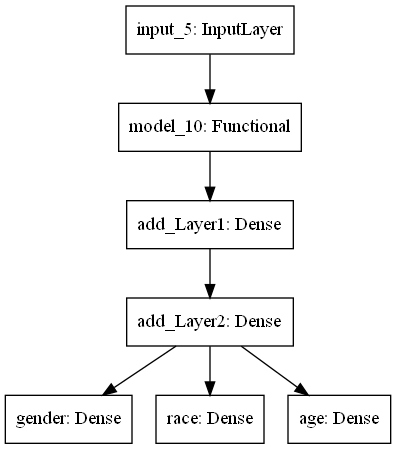

In [124]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# переменная model должна содержать модель для дальнейшего обучения
base = base_model_triple(input_layer)
layer_1_output = Dense(2048, activation='relu', name='add_Layer1')(base)
layer_2_output = Dense(2048, activation='relu', name='add_Layer2')(layer_1_output)
gender_output = Dense(1, activation='sigmoid', name='gender')(layer_2_output)
race_output = Dense(5, activation='softmax', name='race')(layer_2_output)
age_output = Dense(1, activation='sigmoid', name='age')(layer_2_output)
model_triple = tf.keras.Model(inputs=input_layer, outputs=[gender_output, race_output, age_output])

model_triple.summary()
plot_model(model_triple)

In [125]:
prediction = model_triple(np.zeros((6, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32))
assert len(prediction) == 3, "Модель должна возвращать три тензора"
assert prediction[0].shape == (6, 1), f"Неправильный размер выхода gender: {prediction[0].shape}"
assert prediction[1].shape == (6, 5), f"Неправильный размер выхода race: {prediction[1].shape}"
assert prediction[2].shape == (6, 1), f"Неправильный размер выхода age: {prediction[2].shape}"
print("Shape tests passed")

Shape tests passed


In [126]:
df_train.loc[:,'race'] = np.asarray(df_train.loc[:,'race']).astype(np.float32)
df_val.loc[:,'race'] = np.asarray(df_val.loc[:,'race']).astype(np.float32)
df_train.loc[:,'gender'] = np.asarray(df_train.loc[:,'gender']).astype(np.float32)
df_val.loc[:,'gender'] = np.asarray(df_val.loc[:,'gender']).astype(np.float32)

In [127]:
train_generator_triple = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)

val_generator_triple = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)

def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])

    Для такого превращения и нужна эта функция.

    """
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1], 3, axis=1)
        yield image, labels

Found 18946 validated image filenames.
Found 4759 validated image filenames.


In [128]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00004) # вы можете выбрать другую скорость обучения для вашей модели

# обратите внимание, что теперь loss -- это словарь, в котором к каждому выходу мы "прицепляем" свой лосс
# аналогично с metrics
model_triple.compile(optimizer=optimizer,
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'sparse_categorical_accuracy', 'age': 'mae'})

In [129]:
path = Path("model_multitask")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_loss', verbose=1, save_best_only=True, mode='min')

А теперь перейдем к обучению:

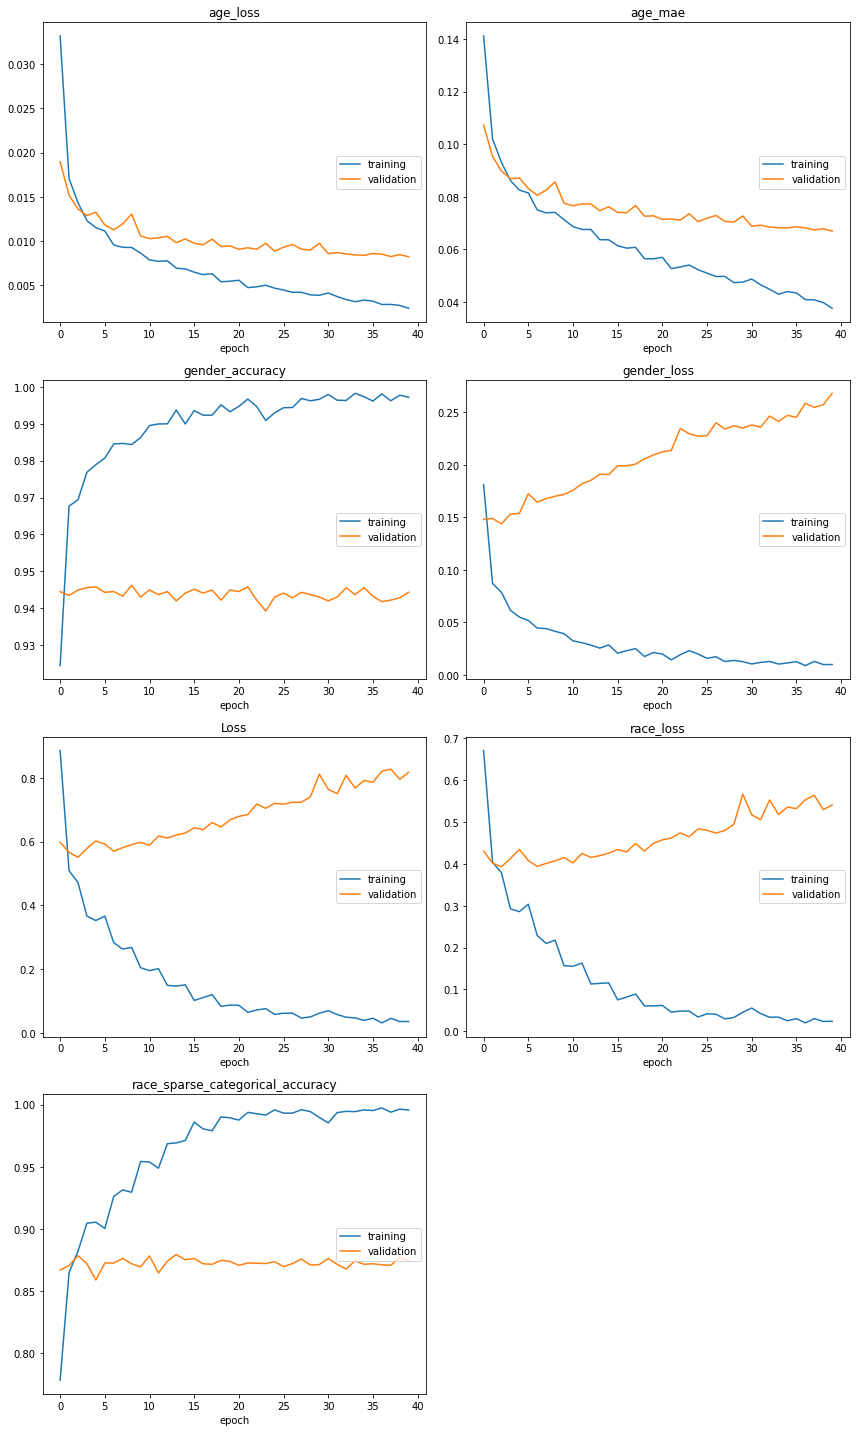

age_loss
	training         	 (min:    0.002, max:    0.033, cur:    0.002)
	validation       	 (min:    0.008, max:    0.019, cur:    0.008)
age_mae
	training         	 (min:    0.038, max:    0.141, cur:    0.038)
	validation       	 (min:    0.067, max:    0.107, cur:    0.067)
gender_accuracy
	training         	 (min:    0.924, max:    0.998, cur:    0.997)
	validation       	 (min:    0.939, max:    0.946, cur:    0.944)
gender_loss
	training         	 (min:    0.009, max:    0.181, cur:    0.010)
	validation       	 (min:    0.144, max:    0.268, cur:    0.268)
Loss
	training         	 (min:    0.032, max:    0.885, cur:    0.036)
	validation       	 (min:    0.551, max:    0.827, cur:    0.817)
race_loss
	training         	 (min:    0.020, max:    0.671, cur:    0.024)
	validation       	 (min:    0.393, max:    0.567, cur:    0.541)
race_sparse_categorical_accuracy
	training         	 (min:    0.778, max:    0.997, cur:    0.996)
	validation       	 (min:    0.859, max:    0.879

In [130]:
history = model_triple.fit(split_outputs(train_generator_triple), epochs=40, 
                           validation_data=split_outputs(val_generator_triple),
                           callbacks=[PlotLossesCallback(), checkpoint], steps_per_epoch=50, 
                           validation_steps=len(df_val)//BATCH_SIZE)

In [137]:
model_multitask = tf.keras.models.load_model("model_multitask/checkpoint_best.h5")
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
results = model_triple.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)
assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
print("Well done!")

Found 4759 validated image filenames.
37/37 [==============================] - 9s 250ms/step - loss: 0.8161 - gender_loss: 0.2669 - race_loss: 0.5410 - age_loss: 0.0082 - gender_accuracy: 0.9447 - race_sparse_categorical_accuracy: 0.8748 - age_mae: 0.0669
Well done!


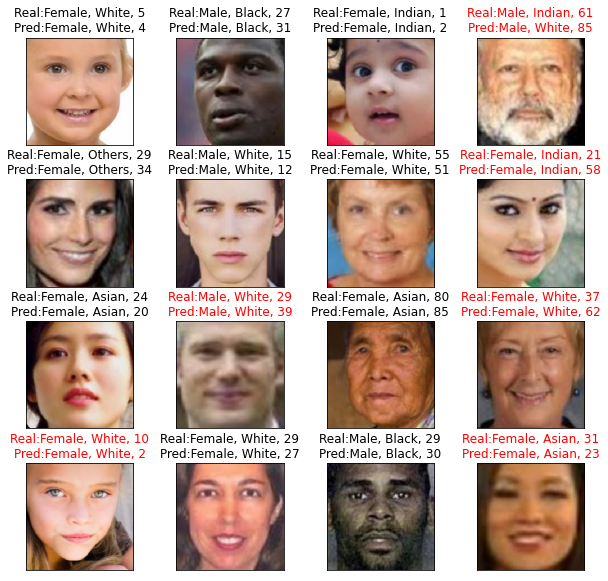

In [138]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten())

b) Загрузите любое лицо и получите предсказание. Не забудьте его обрезать соответствующим образом. Результат сети не оценивается.

Downloading...
From: https://top4man.ru/inews/aHR0cHM6Ly9zbS1uZXdzLnJ1L3dwLWNvbnRlbnQvdXBsb2Fkcy8yMDIwLzEyLzAyLzg3MzBjNjY5NzhkNzM4YjA5YjI4ZTM3MDZiYWUwMWE5LmpwZw==
To: C:\Users\User\YandexDisk\Skillbox\8. Data Scientist. ML. Средний уровень (нейронные сети)\5. Свёрточные нейросети для задачи классификации изображений. Часть 2\5.10 Домашняя работа\me.jpg
449kB [00:00, 2.62MB/s]


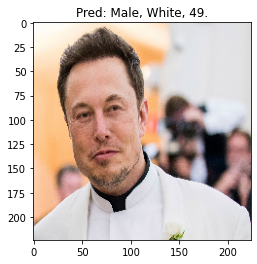

In [141]:
url = 'https://top4man.ru/inews/aHR0cHM6Ly9zbS1uZXdzLnJ1L3dwLWNvbnRlbnQvdXBsb2Fkcy8yMDIwLzEyLzAyLzg3MzBjNjY5NzhkNzM4YjA5YjI4ZTM3MDZiYWUwMWE5LmpwZw=='
output = 'me.jpg'
gdown.download(url, output, quiet=False)

img = image.load_img("me.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model_triple.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."
_ = plt.title(title_obj)